In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive') # Mount your Google Drive to access the datasets, make sure to authorize in the pop-up window

Mounted at /content/drive


In [3]:
test_data = pd.read_csv("/content/drive/My Drive/DSF Datasets/test_detrended.csv")
train_data = pd.read_csv("/content/drive/My Drive/DSF Datasets/train_detrended.csv")
seasonality_df = pd.read_csv("/content/drive/My Drive/DSF Datasets/seasonality_components.csv")


In [4]:
#don't need to standardize because: As long as the series is stationary, the scale of the data does not affect the model's performance.

In [5]:
test_data.head()

,DATE,WATER_LEVEL,HUMIDITY,MEAN_TEMP,PRECIPITATION,PRESSURE,SNOW_DEPTH,SUNSHINE,WIND_SPEED,GLOBAL_RADIATION,...,MOON_ILLUMINATION,CLIMATE_CHANGE,WATER_LEVEL_LAG_1,WATER_LEVEL_LAG_2,WATER_LEVEL_LAG_3,WATER_LEVEL_LAG_4,WATER_LEVEL_LAG_5,WATER_LEVEL_LAG_6,WATER_LEVEL_LAG_7,LOG_WATER_LEVEL
0,2018-01-01,5.814955,54.966096,158.185998,25.503455,10126.490282,0.343520,101.963267,51.218443,160.392824,...,93.24608,0.261758,5.813526,5.812020,5.815046,5.817408,5.820889,5.827840,5.837170,5.823046
1,2018-01-02,5.834879,61.616171,126.354992,27.376329,10084.646488,0.358823,84.066813,50.943048,157.222570,...,98.02259,0.261758,5.836918,5.834440,5.835472,5.839615,5.843447,5.848409,5.856328,5.823046
2,2018-01-03,5.838346,62.614585,125.849908,42.411914,10081.639138,-0.564266,78.011627,50.787032,166.943577,...,99.91610,0.261758,5.837851,5.836957,5.834469,5.835498,5.839636,5.843466,5.848431,5.823046
3,2018-01-04,5.853000,69.275557,142.172221,92.154747,9992.490891,-1.038637,43.056889,56.794486,128.933991,...,98.74032,0.261758,5.841307,5.837891,5.836987,5.834496,5.835521,5.839657,5.843489,5.834811
4,2018-01-05,5.885116,77.101825,138.843850,136.285037,9982.019579,-0.730957,57.625725,57.127055,137.166870,...,94.64586,0.261758,5.855919,5.841348,5.837921,5.837015,5.834520,5.835542,5.839681,5.872118


In [6]:
#ARMA according to: https://www.geeksforgeeks.org/arma-time-series-model/
#roling forecast according to: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/


In [7]:
#set date as index to ensure temporal order
#ARMA models are designed to work on univariate time series, i.e., a single variable (the target) -> drop all cols except for water levels
train_data = train_data[['DATE', 'WATER_LEVEL']]
test_data = test_data[['DATE', 'WATER_LEVEL']]
train_data['DATE'] = pd.to_datetime(train_data['DATE'])

test_data['DATE'] = pd.to_datetime(test_data['DATE'])

print(test_data.head())

        DATE  WATER_LEVEL
0 2018-01-01     5.814955
1 2018-01-02     5.834879
2 2018-01-03     5.838346
3 2018-01-04     5.853000
4 2018-01-05     5.885116


<ipython-input-7-ccde763f72cb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['DATE'] = pd.to_datetime(train_data['DATE'])
<ipython-input-7-ccde763f72cb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['DATE'] = pd.to_datetime(test_data['DATE'])


In [8]:
#make copy for plotting afterwards:

train_copy=train_data.copy()
train_c2 = train_data.copy()
test_copy=test_data.copy()

In [9]:
#split into test and train seasonality:
train_seasonality = seasonality_df[seasonality_df['dataset'] == 'train']
test_seasonality = seasonality_df[seasonality_df['dataset'] == 'test']


seasonality_df['date'] = pd.to_datetime(seasonality_df['date'])

train_seasonality.head()
test_seasonality.head()

,date,dataset,column,seasonal_value
16436,2018-01-01,test,WATER_LEVEL,0.008091
16437,2018-01-02,test,WATER_LEVEL,-0.011834
16438,2018-01-03,test,WATER_LEVEL,-0.015300
16439,2018-01-04,test,WATER_LEVEL,-0.018189
16440,2018-01-05,test,WATER_LEVEL,-0.012998


In [10]:
#Perform grid search with cross-validation for ARMA hyperparameters
best_rmse = float('inf')
best_order = None

# List of possible p and q values to tune
# ARMA parameter values to test:
#The p parameter controls how many past values of the time series are used to predict the current value.
#It represents the number of lagged observations included in the model.
#The q parameter controls how many past forecast errors (residuals) are used to predict the current value.
#It defines the number of lagged forecast errors in the prediction equation.
#choose both smaller than 3 because Higher values of p and q can result in overly complex models that might fit the training data too well (overfitting),
# but perform poorly on unseen test data.
p_values = [1, 2, 3, 4, 5]
q_values = [1, 2, 3, 4, 5]

train_data = train_data['WATER_LEVEL'].values

In [11]:
# Perform cross-validation for each combination of p and q
#enough to make it without seasonality and then add it to compare because just need the numbers
for p in p_values:
    for q in q_values:
        rmse_values = []

        # Time Series Cross-Validation
        tscv = TimeSeriesSplit(n_splits=5)
        for train_index, val_index in tscv.split(train_data):
            train, val = train_data[train_index], train_data[val_index]

            # set d=0 for ARMA
            model = ARIMA(train, order=(p, 0, q))
            model_fit = model.fit()

            # Forecast the validation set
            forecast = model_fit.forecast(steps=len(val))
            rmse = np.sqrt(mean_squared_error(val, forecast))
            rmse_values.append(rmse)

        # Average RMSE over all folds
        avg_rmse = np.mean(rmse_values)

        # Update the best model
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_order = (p, 0, q)

print(f"Best parameters: p={best_order[0]}, q={best_order[2]} with RMSE: {best_rmse:.4f}")

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best parameters: p=4, q=3 with RMSE: 0.0956


In [12]:
print(best_order)

(4, 0, 3)


In [13]:
train_copy.head()

,DATE,WATER_LEVEL
0,1973-01-01,5.751083
1,1973-01-02,5.747830
2,1973-01-03,5.744990
3,1973-01-04,5.742506
4,1973-01-05,5.737028


In [14]:
#fit model on train data:
final_model = ARIMA(train_copy['WATER_LEVEL'], order=best_order)
final_model_fit = final_model.fit()

In [15]:
# Initialize history with training data
history = [x for x in train_copy['WATER_LEVEL']]

predictions = []

# Create a dictionary for seasonal components with dates as keys
seasonality_dict = {
    row['date']: row['seasonal_value']
    for _, row in seasonality_df[seasonality_df['dataset'] == 'test'].iterrows()
}

In [16]:
# Train the ARIMA model once on the entire training data

model = ARIMA(history, order=best_order)
model_fit = model.fit()

In [17]:
#need to use Rolling Forecast (day to day) otherwise just takes mean on the test set when everything at the same time
#need to reverse deseasoning and log transformation before taking mean squared error!!

In [18]:
train_seasonality_dict = {
    row['date']: row['seasonal_value']
    for _, row in seasonality_df[seasonality_df['dataset'] == 'train'].iterrows()
}

In [19]:
print(train_copy.columns)

Index(['DATE', 'WATER_LEVEL'], dtype='object')


In [20]:
#use ast value of the training data as the first prediction, as it is common for ARMA to have poorer accuracy for the first few predictions
last_train_date = train_copy.iloc[-1]['DATE']  # Last date
last_train_value = train_copy.iloc[-1]['WATER_LEVEL']

In [21]:
# Ensure the last training date is correctly formatted
last_train_date = train_copy.iloc[-1]['DATE'].strftime('%Y-%m-%d')
last_train_value = train_copy.iloc[-1]['WATER_LEVEL']
last_train_value

5.938376386195032

In [22]:
# Fetch the corresponding seasonal adjustment for the last training date
last_seasonal_row = train_seasonality.iloc[-1]

seasonal_adjustment = last_seasonal_row['seasonal_value']
seasonal_adjustment

-0.1212652262318283

In [23]:
train_copy = train_copy.reset_index(drop=True)



# Generate the first prediction based on the last value in the training set
arima_forecast = model_fit.forecast(steps=1)[0]
first_prediction = last_train_value + seasonal_adjustment



In [24]:
first_prediction

5.817111159963204

In [27]:

print(f"First Prediction - Date: {last_train_date}, Predicted (log): {first_prediction}")
test_data['DATE'] = pd.to_datetime(test_data['DATE'], errors='coerce')

for t in range(len(test_data)):
    yhat = model_fit.forecast(steps=1)[0]
    # Extract the forecast date dynamically
    forecast_date = test_data.iloc[t]['DATE']
    forecast_date_str = forecast_date.strftime('%Y-%m-%d')

    predictions.append(yhat)

    # Prepare the actual observed value
    obs = test_data.iloc[t]['WATER_LEVEL']


    history.append(obs)
    model_fit = model_fit.append([obs])

    # Debugging outputs
    print(f"Date: {forecast_date_str}, Predicted (log): {yhat}, Actual (log): {obs}")


First Prediction - Date: 2017-12-31, Predicted (log): 5.817111159963204
Date: 2018-01-01, Predicted (log): 5.940946711907813, Actual (log): 5.814954840830426
Date: 2018-01-02, Predicted (log): 5.72084594907203, Actual (log): 5.834879420759664
Date: 2018-01-03, Predicted (log): 5.869488495803761, Actual (log): 5.8383458262827
Date: 2018-01-04, Predicted (log): 5.831215168077644, Actual (log): 5.853000154684136
Date: 2018-01-05, Predicted (log): 5.862854445523225, Actual (log): 5.885115699479407
Date: 2018-01-06, Predicted (log): 5.904767028744188, Actual (log): 5.897885601458011
Date: 2018-01-07, Predicted (log): 5.900824439659273, Actual (log): 5.901472273132622
Date: 2018-01-08, Predicted (log): 5.90163536387216, Actual (log): 5.902672620361616
Date: 2018-01-09, Predicted (log): 5.901922296047247, Actual (log): 5.905975125674675
Date: 2018-01-10, Predicted (log): 5.907023555944115, Actual (log): 5.910198592466273
Date: 2018-01-11, Predicted (log): 5.911552202516196, Actual (log): 5.90

In [30]:
print(predictions)


[5.940946711907813, 5.940946711907813, 5.940946711907813, 5.72084594907203, 5.869488495803761, 5.831215168077644, 5.862854445523225, 5.904767028744188, 5.900824439659273, 5.90163536387216, 5.901922296047247, 5.907023555944115, 5.911552202516196, 5.905268525110736, 5.910334971822051, 5.907024006443859, 5.902355337562042, 5.890704325095415, 5.8947299278620235, 5.907403525262863, 5.911147973624662, 5.925031012346158, 5.927300769552493, 5.931231567134683, 5.949065402071835, 5.987755880337204, 5.985123938371309, 5.978673695409637, 5.978526477699241, 5.978776411809104, 5.972856249312558, 5.970293020757163, 5.961882165864281, 5.956783384584953, 5.94260579194953, 5.94701565439601, 5.9270020954584615, 5.906759881215013, 5.900278188212574, 5.9016427475020805, 5.903895389872306, 5.907240742955329, 5.89918544136742, 5.902558994571162, 5.894640460342164, 5.8868672397891375, 5.888008305512828, 5.875002872633923, 5.868818569776396, 5.890408506361181, 5.904459648879657, 5.907600742270668, 5.8965825651

In [31]:
#took first prediction 3 times -> drop first two times:
predictions = predictions[2:]
print(predictions)

[5.940946711907813, 5.72084594907203, 5.869488495803761, 5.831215168077644, 5.862854445523225, 5.904767028744188, 5.900824439659273, 5.90163536387216, 5.901922296047247, 5.907023555944115, 5.911552202516196, 5.905268525110736, 5.910334971822051, 5.907024006443859, 5.902355337562042, 5.890704325095415, 5.8947299278620235, 5.907403525262863, 5.911147973624662, 5.925031012346158, 5.927300769552493, 5.931231567134683, 5.949065402071835, 5.987755880337204, 5.985123938371309, 5.978673695409637, 5.978526477699241, 5.978776411809104, 5.972856249312558, 5.970293020757163, 5.961882165864281, 5.956783384584953, 5.94260579194953, 5.94701565439601, 5.9270020954584615, 5.906759881215013, 5.900278188212574, 5.9016427475020805, 5.903895389872306, 5.907240742955329, 5.89918544136742, 5.902558994571162, 5.894640460342164, 5.8868672397891375, 5.888008305512828, 5.875002872633923, 5.868818569776396, 5.890408506361181, 5.904459648879657, 5.907600742270668, 5.896582565133519, 5.898873484631123, 5.8934643307

In [32]:
#add seasonality back to predictions:
test_copy['DATE'] = pd.to_datetime(test_copy['DATE'], errors='coerce')
test_seasonality['date'] = pd.to_datetime(test_seasonality['date'], errors='coerce')

test_seasonality_filtered = test_seasonality.set_index('date')

seasonal_adjustments = test_seasonality_filtered['seasonal_value'].reindex(test_copy['DATE'])
predictions_series = pd.Series(predictions, index=test_copy['DATE'])
adjusted_predictions = predictions_series.add(seasonal_adjustments, fill_value=0)

adjusted_predictions_array = adjusted_predictions.values


print(adjusted_predictions_array)

[5.94903777 5.70901242 5.85418857 ... 5.9515559  5.94955066 5.95000915]


<ipython-input-32-3e24c1c86e36>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seasonality['date'] = pd.to_datetime(test_seasonality['date'], errors='coerce')


In [33]:
#do same for original test data:
seasonal_adjustments = test_seasonality_filtered['seasonal_value'].reindex(test_copy['DATE'])

test_copy['Adjusted_WATER_LEVEL'] = test_copy['WATER_LEVEL'] + seasonal_adjustments.values

print(test_copy.head())

        DATE  WATER_LEVEL  Adjusted_WATER_LEVEL
0 2018-01-01     5.814955              5.823046
1 2018-01-02     5.834879              5.823046
2 2018-01-03     5.838346              5.823046
3 2018-01-04     5.853000              5.834811
4 2018-01-05     5.885116              5.872118


In [34]:
#as first and second predictions are bad use last of training data as first prediction to make it fair in comparison to the other madels:
#reason: The model might make poor forecasts initially, especially for the first prediction, because it lacks real feedback from the test data.
adjusted_predictions_array[0] = first_prediction
print(adjusted_predictions_array)


[5.81711116 5.70901242 5.85418857 ... 5.9515559  5.94955066 5.95000915]


In [35]:
# Apply the exponential transformation after the loop
adjusted_predictions_array = np.exp(adjusted_predictions_array)

print(adjusted_predictions_array)

[336.         301.57309476 348.69184446 ... 384.35088703 383.58094285
 383.75685014]


In [36]:
test_copy["Adjusted_WATER_LEVEL"] = np.exp(test_copy["Adjusted_WATER_LEVEL"])

print(test_copy)

           DATE  WATER_LEVEL  Adjusted_WATER_LEVEL
0    2018-01-01     5.814955                 338.0
1    2018-01-02     5.834879                 338.0
2    2018-01-03     5.838346                 338.0
3    2018-01-04     5.853000                 342.0
4    2018-01-05     5.885116                 355.0
...         ...          ...                   ...
2186 2023-12-27     5.998746                 392.0
2187 2023-12-28     5.993272                 388.0
2188 2023-12-29     5.990602                 385.0
2189 2023-12-30     5.978306                 380.0
2190 2023-12-31     5.947392                 376.0

[2191 rows x 3 columns]


In [37]:
#everything okay because are same as in initial dataset

In [38]:
#calculate RMSE:
from sklearn.metrics import mean_squared_error


# NumPy array
adjusted_water_levels = test_copy['Adjusted_WATER_LEVEL'].values

# Ensure both arrays have the same length
assert len(adjusted_water_levels) == len(adjusted_predictions_array), \
    "Adjusted water levels and predictions must have the same length."

# Calculate RMSE
rmse_arma = np.sqrt(mean_squared_error(adjusted_water_levels, adjusted_predictions_array))

print(f"RMSE: {rmse_arma}")

RMSE: 2.1234948015420985


In [39]:
# to plot redo log and add seasonality on train set

train_copy['DATE'] = pd.to_datetime(train_copy['DATE'], errors='coerce')
train_seasonality['date'] = pd.to_datetime(train_seasonality['date'], errors='coerce')

train_seasonality_filtered = train_seasonality.set_index('date')

seasonal_adjustments = train_seasonality_filtered['seasonal_value'].reindex(train_copy['DATE'])

# Add seasonal adjustments to WATER_LEVEL in train_copy
train_copy['Adjusted_WATER_LEVEL'] = train_copy['WATER_LEVEL'] + seasonal_adjustments.values

# Debugging output
print(train_copy.head())




        DATE  WATER_LEVEL  Adjusted_WATER_LEVEL
0 1973-01-01     5.751083              5.634790
1 1973-01-02     5.747830              5.631212
2 1973-01-03     5.744990              5.627621
3 1973-01-04     5.742506              5.624018
4 1973-01-05     5.737028              5.616771


<ipython-input-39-2a6fb73650b5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seasonality['date'] = pd.to_datetime(train_seasonality['date'], errors='coerce')


In [40]:
train_copy['Adjusted_WATER_LEVEL']= np.exp(train_copy['Adjusted_WATER_LEVEL'])
train_copy

,DATE,WATER_LEVEL,Adjusted_WATER_LEVEL
0,1973-01-01,5.751083,280.0
1,1973-01-02,5.747830,279.0
2,1973-01-03,5.744990,278.0
3,1973-01-04,5.742506,277.0
4,1973-01-05,5.737028,275.0
...,...,...,...
16431,2017-12-27,5.937352,338.0
16432,2017-12-28,5.936955,337.0
16433,2017-12-29,5.935104,336.0
16434,2017-12-30,5.933522,335.0


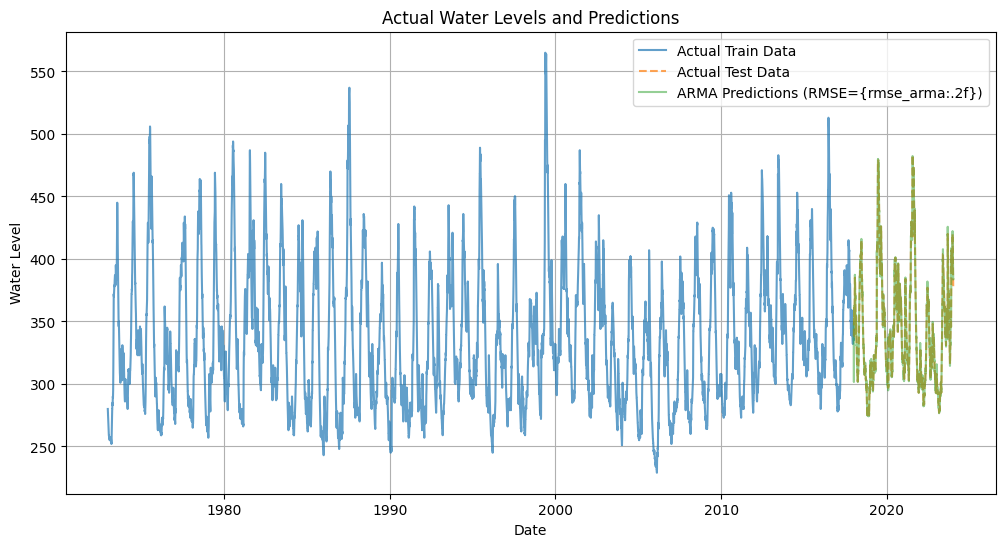

In [41]:
# Plot results
import matplotlib.pyplot as plt

train_copy['DATE'] = pd.to_datetime(train_copy['DATE'], errors='coerce')
test_copy['DATE'] = pd.to_datetime(test_copy['DATE'], errors='coerce')
predictions_series = pd.Series(adjusted_predictions_array, index=test_copy['DATE'])

plt.figure(figsize=(12, 6))
plt.plot(train_copy['DATE'], train_copy['Adjusted_WATER_LEVEL'], label='Actual Train Data', linestyle='-', alpha=0.7)

plt.plot(test_copy['DATE'], test_copy['Adjusted_WATER_LEVEL'], label='Actual Test Data', linestyle='--', alpha=0.7)

plt.plot(predictions_series.index, predictions_series.values, label='ARMA Predictions (RMSE={rmse_arma:.2f})', linestyle='-', alpha=0.5)


plt.xlabel('Date')
plt.ylabel('Water Level')
plt.title('Actual Water Levels and Predictions')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

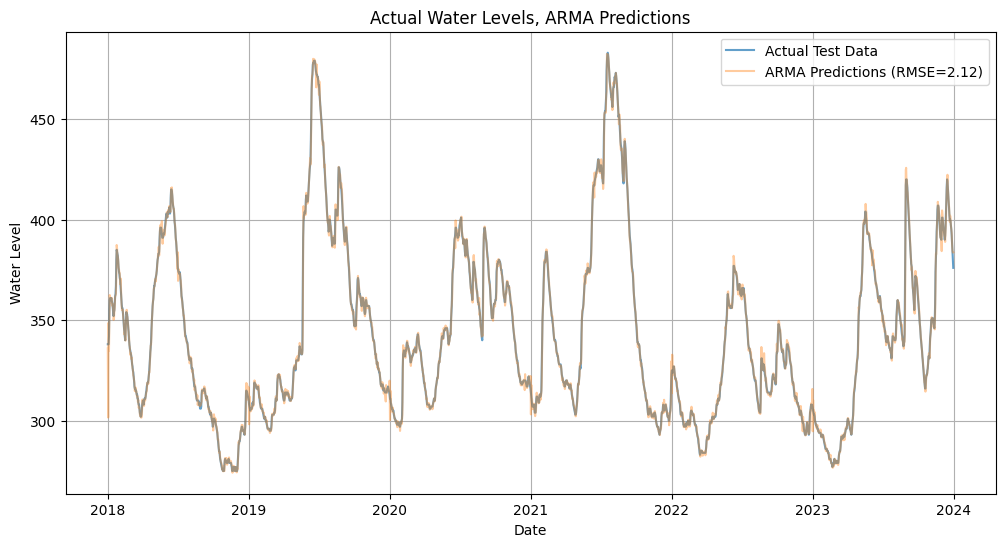

In [44]:

plt.figure(figsize=(12, 6))
plt.plot(test_copy['DATE'][0:], test_copy['Adjusted_WATER_LEVEL'], label='Actual Test Data', alpha=0.7)
plt.plot(test_copy['DATE'][0:], predictions_series.values, label=f'ARMA Predictions (RMSE={rmse_arma:.2f})', alpha=0.4)
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.title('Actual Water Levels, ARMA Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
#performs surprisingly well, reasons for that:
#ARMA models excel at capturing patterns in data that have strong autocorrelation which means, that past values heavily influence future values. THis is the case with water
#levels
#ARMA assumes that the data can be explained using only its own lags and moving averages. So if the data is primarily driven by internal dynamics (and not external factors),
#ARMA will perform better, this can also be seen by the feature importance of the other models where lag 1 has the highest feature importance.



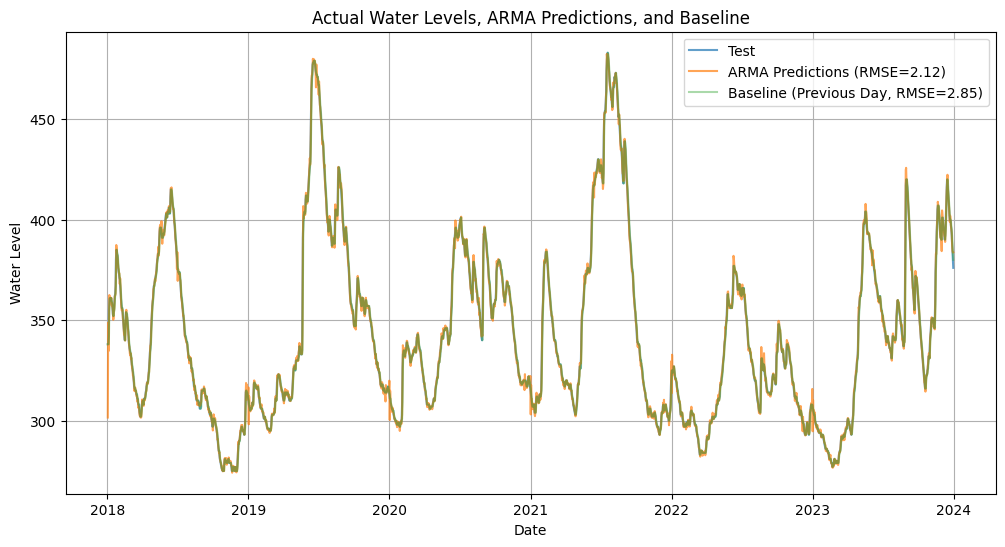

In [49]:
#plotting with the use of previous day data as baseline:
baseline_predictions = test_copy['Adjusted_WATER_LEVEL'].shift(1)


baseline_predictions = baseline_predictions[1:]
adjusted_test_data = test_copy['Adjusted_WATER_LEVEL'][1:]
arma_predictions = adjusted_predictions_array[1:]

#calculate RMSE from baseline to compare
rmse_baseline = np.sqrt(mean_squared_error(adjusted_test_data, baseline_predictions))
rmse_arma = np.sqrt(mean_squared_error(adjusted_test_data, arma_predictions))

plt.figure(figsize=(12, 6))
plt.plot(test_copy['DATE'][1:], adjusted_test_data, label='Test', alpha=0.7)
plt.plot(test_copy['DATE'][1:], arma_predictions, label=f'ARMA Predictions (RMSE={rmse_arma:.2f})', alpha=0.7)
plt.plot(test_copy['DATE'][1:], baseline_predictions, label=f'Baseline (Previous Day, RMSE={rmse_baseline:.2f})', linestyle='-', alpha=0.4)
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.title('Actual Water Levels, ARMA Predictions, and Baseline')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
#If the AR component dominates, the predictions heavily rely on patterns or trends from past values.

In [51]:
#calculate improvement of model compared to baseline (of last day)
improvement = ((rmse_baseline - rmse_arma) / rmse_baseline) * 100
improvement

25.526584437525525

In [52]:
#A ~25% improvement in RMSE is significant, especially for operational contexts like ferry management, where even small improvements can have real-world impacts on
#scheduling, cost, and safety.


In the context of ferry operations at Lake Constance, a ~25% reduction in RMSE could translate to meaningful operational benefits:

Improved Prediction Accuracy:
Better accuracy means fewer operational disruptions caused by incorrect forecasts.
Even small improvements in water level forecasts could help ferry companies make better decisions regarding:
Adjusting schedules.
Communicating with customers about restrictions.
Managing cargo loads.

Reduced Risk and Cost:
More accurate predictions lower the chances of unnecessary delays, accidents, or damage caused by high/low water levels.
This can save costs associated with repairs, additional trips, and lost customer trust.

Operational Efficiency:
Proactive measures can be taken earlier with greater confidence, reducing inefficiencies.

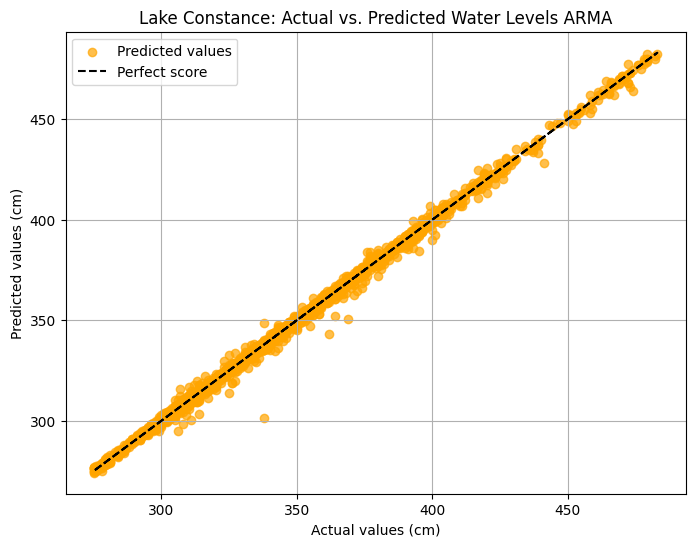

In [57]:
actual_values = test_copy['Adjusted_WATER_LEVEL']
predicted_values = predictions_series.values

plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, color='orange', label='Predicted values', alpha=0.7)
plt.plot(actual_values, actual_values, 'k--', label='Perfect score')

plt.xlabel('Actual values (cm)')
plt.ylabel('Predicted values (cm)')
plt.title('Lake Constance: Actual vs. Predicted Water Levels ARMA')
plt.legend()
plt.grid(True)

plt.show()